# Proposed Graph
- Updated 2023.02.32
- Written by shyeon

### Preparing to run the code

In [1]:
import os
from pathlib import Path

curr_path = Path().absolute()
os.chdir(curr_path.parent)  # change working directory to parent path

In [2]:
import pickle
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from networkx.exception import NetworkXError
from pyvis.network import Network
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.logger import get_logger

logger = get_logger()
random_seed = 42

### Loading & processing dataset

In [3]:
with open("data/processed/values.pickle","rb") as f:
    value_df = pickle.load(f)

test_items = value_df.columns.tolist()
item_2_idx = {v: k for k, v in enumerate(test_items)}
idx_2_item = {k: v for k, v in enumerate(test_items)}

- scaling using standard scaler
- divide into train & test dataset

In [4]:
train, test = train_test_split(value_df, test_size=0.5, random_state=random_seed, shuffle=False)
scaler = StandardScaler().fit(train)
# scaled_train = pd.DataFrame(scaler.transform(train), columns=train.columns)
# scaled_test = pd.DataFrame(scaler.transform(test), columns=test.columns)
scaled_train = pd.DataFrame(scaler.transform(train))
scaled_test = pd.DataFrame(scaler.transform(test))
titles = train.columns.tolist()

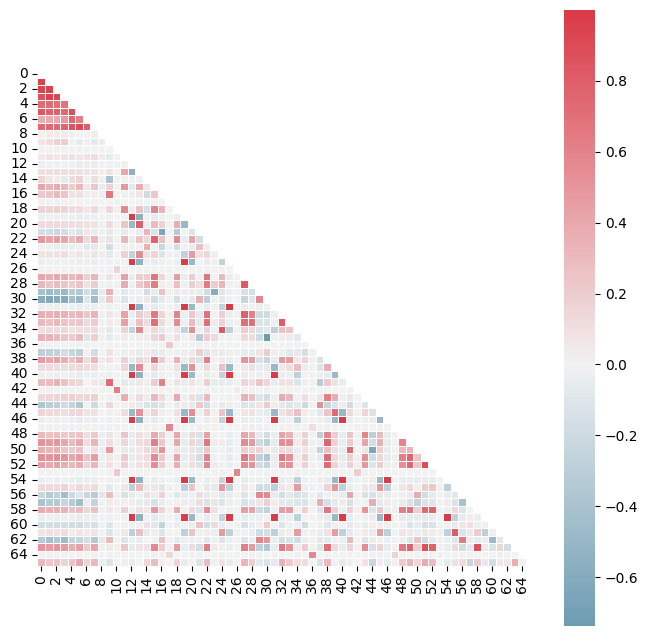

In [5]:
def corr_graph(matrix: np.array):
    mask = np.triu(np.ones_like(matrix, dtype=bool))  # 역 삼각 모양 마스크
    f, ax = plt.subplots(figsize=(8, 8))
    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5)

train_corr = scaled_train.corr()
corr_graph(train_corr) # visualization

### Rank feature importance
- make graph instance using Networkx

In [6]:
pos = pd.read_csv("notebook/position.csv", index_col="node")  # position of nodes

def build_nx_graph(
    corr_mat: pd.DataFrame,
    titles: list[str],
    pos: pd.DataFrame | None = None,
    highlights: list[str] | None = None,
    threshold: float = 0.0,
) -> nx.Graph:
    """Build a graph using Python's NetworkX library

    Args:
        corr_mat (pd.DataFrame): A matrix representing the correlation values between paired nodes
        titles (list[str]): Node titles
        pos (pd.DataFrame | None, optional): Location of nodes in a graph. Defaults to None.
        highlights (list[str] | None, optional): Highlighted node with a specific color. Defaults to None.
        threshold (float, optional): _description_. Defaults to 0.0.

    Returns:
        nx.Graph: a directed graph with the NetworkX library
            to model the relationships between nodes in RF test items
    """

    G = nx.Graph()
    for i, title in enumerate(titles):
        G.add_node(i, label=f"Node {i}", title=title)
    for n1, n2 in combinations(G.nodes, 2):
        if abs(corr_mat.loc[n1, n2]) < threshold:  # there is no edges btw node1 and node2
            continue
        G.add_edges_from([(n1, n2, {"value": abs(corr_mat.loc[n1, n2])})])
    if pos is not None:
        assert G.number_of_nodes() == len(pos)
        for index, (x, y) in pos.iterrows():
            G.nodes[index]["x"], G.nodes[index]["y"] = x, y
    if highlights is not None:
        for node in highlights:
            G.nodes[node]["color"] = "#dd4b39"
    return G.to_directed()

G = build_nx_graph(train_corr, titles, pos=pos, threshold=0.6)

- Visualization using pyvis

In [ ]:
net = Network("1500px", "1500px")
net.force_atlas_2based()
net.from_nx(G)

- New PageRank

In [ ]:
def proposed_pagerank(
    G: nx.Graph,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
    init_penalty=0.8,
    velocity=None,
):
    # Convert to a directed graph
    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G
    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight="initial")
    N = W.number_of_nodes()
    # Set initial PR scores
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)  # Choose fixed starting vector if not given
    else:
        s = float(sum(nstart.values()))  # Normalized nstart vector
        x = dict((k, v / s) for k, v in nstart.items())
    # Set personalization
    if personalization is None:
        p = dict.fromkeys(W, 1.0 / N)  # Assign uniform personalization vector if not given
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise nx.NetworkXError(
                f"Personalization dictionary must have a value for every node. nodes {missing}"
            )
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())
    # Handling with dangling
    if dangling is None:
        dangling_weights = p  # Use personalization vector if dangling vector not specified
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise nx.NetworkXError(
                f"Dangling node dictionary must have a value for every node. nodes {missing}"
            )
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v / s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    selected_nodes = []
    for _ in range(len(G)):
        # Initailize penality terms
        penalty_rates = dict.fromkeys(G, 1)  # all dict value is 1
        for sel_n in selected_nodes:
            for nbr in G[sel_n]:
                penalty_rates[nbr] *= init_penalty ** G[sel_n][nbr][weight]
        # power iteration: make up to max_iter iterations
        for i in range(max_iter):
            xlast = x
            x = dict.fromkeys(xlast.keys(), 0)
            danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
            for n in x:
                penalty = (
                    penalty_rates[n] if velocity is None else penalty_rates[n] ** (i / velocity)
                )
                for nbr in W[n]:
                    x[nbr] += alpha * xlast[n] * W[n][nbr]["initial"] * penalty
                x[n] += danglesum * dangling_weights[n] + (1.0 - alpha * penalty) * p[n]
            # check convergence, l1 norm
            err = sum([abs(x[n] - xlast[n]) for n in x])
            if err < N * tol:
                break
        # select the best score & new node
        ordered_nodes = pd.Series(x).sort_values(ascending=True).keys()
        for ord_n in ordered_nodes:
            if ord_n not in selected_nodes:
                selected_nodes.append(ord_n)
                break
    return selected_nodes

sorted_feature_by_importance = proposed_pagerank(G, weight="value")


In [ ]:
for num in range(len(sorted_feature_by_importance)):
    G = build_nx_graph(train_corr, titles, pos=pos, highlights=sorted_feature_by_importance[:num], threshold=0.6)
    net = Network("1500px", "1500px")
    net.force_atlas_2based()
    net.from_nx(G)
    net.write_html(f"data/visual/html/nx_{num:02d}.html")

### Train model & evaluation

In [ ]:
def predict_one(
    trainset: pd.DataFrame,
    testset: pd.DataFrame,
    xs: list[str],
    y: str,
    random_seed: int = 42,
) -> float:
    x_train, y_train = trainset[xs].values, trainset[y].values
    x_test, y_test = testset[xs].values, testset[y].values
    model = lgb.LGBMRegressor(random_state=random_seed)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

In [ ]:
def predict_all(trainset: pd.DataFrame, testset: pd.DataFrame, rank: pd.Series, start_num: int, step: int) -> list[tuple]:
    eval_mat = []
    for num_ft in range(start_num, len(trainset.columns), step):
        logger.info(f"current loop: {num_ft}")
        xs = rank[:num_ft]
        ys = rank[num_ft:]
        scores = [predict_one(trainset, testset, xs, y) for y in ys]
        eval_mat.append((num_ft, np.mean(scores), max(scores), min(scores)))
    return eval_mat

In [ ]:
eval_mat = predict_all(scaled_train, scaled_test, sorted_feature_by_importance, start_num=1, step=2)

2023-02-10 15:29:45.810 | INFO     | __main__:predict_all:4 - current loop: 1
2023-02-10 15:29:51.395 | INFO     | __main__:predict_all:4 - current loop: 3
2023-02-10 15:30:00.495 | INFO     | __main__:predict_all:4 - current loop: 5
2023-02-10 15:30:08.768 | INFO     | __main__:predict_all:4 - current loop: 7
2023-02-10 15:30:17.628 | INFO     | __main__:predict_all:4 - current loop: 9
2023-02-10 15:30:27.541 | INFO     | __main__:predict_all:4 - current loop: 11
2023-02-10 15:30:37.749 | INFO     | __main__:predict_all:4 - current loop: 13
2023-02-10 15:30:46.978 | INFO     | __main__:predict_all:4 - current loop: 15
2023-02-10 15:30:56.224 | INFO     | __main__:predict_all:4 - current loop: 17
2023-02-10 15:31:06.203 | INFO     | __main__:predict_all:4 - current loop: 19
2023-02-10 15:31:16.897 | INFO     | __main__:predict_all:4 - current loop: 21
2023-02-10 15:31:28.001 | INFO     | __main__:predict_all:4 - current loop: 23
2023-02-10 15:31:48.481 | INFO     | __main__:predict_all

In [ ]:
eval_mat_df = pd.DataFrame().from_records(eval_mat, columns=["NUM_FEATURES", "MEAN", "MAX", "MIN"])
eval_mat_df = eval_mat_df.set_index("NUM_FEATURES")

<AxesSubplot: xlabel='NUM_FEATURES'>

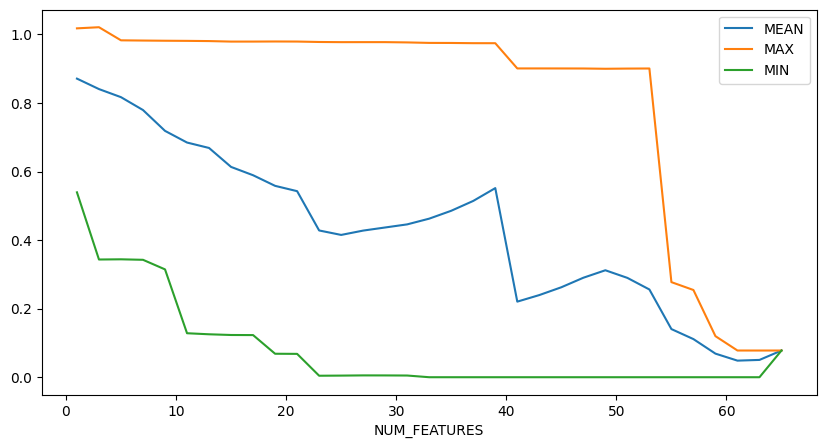

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_mat_df.plot(ax=ax)

<AxesSubplot: xlabel='NUM_FEATURES'>

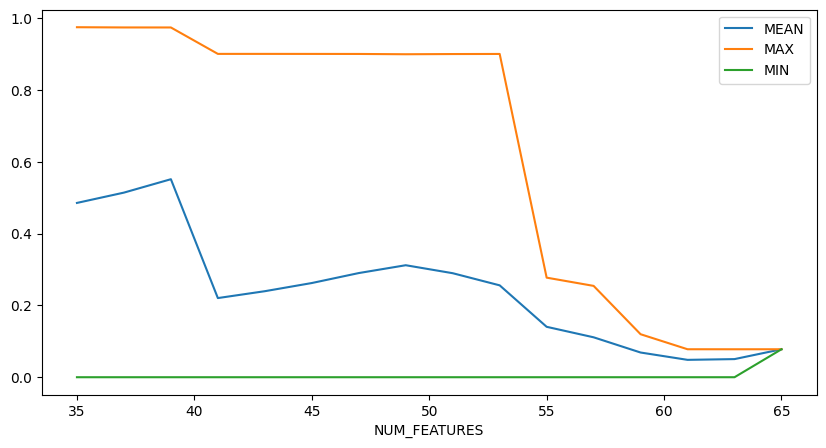

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_mat_df.loc[35:, :].plot(ax=ax)